In [1]:
import re
import tensorflow as tf

In [2]:
filename = 'data/raw_text/aesop_fable.txt'

with open(filename, 'r', encoding='utf-8-sig') as f:
    raw_text = f.read()

In [3]:
print(raw_text[:10])

The Wolf A


In [4]:
import numpy as np
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [27]:
import re

file_name = "data/GloVe/glove.6B.50d.txt"

embedding = {}
idx_to_word = {}
word_to_idx = {}
bad_lines = 0

with open(file_name, 'r', encoding='UTF-8') as f:
    for idx, line in enumerate(f):
        try:
            line = line.strip()
            match_obj = re.match(r'([^\s]+)', line)
            word = match_obj.group(1)
            word_len = len(word)
            word_vec = line[word_len:].replace('\n', '')

            embed = word_vec.strip()
            embed = embed.split()
            embed = np.array(embed, dtype=np.float32)
            
            embedding[idx] = [embed]
            idx_to_word[idx] = word.strip()
            word_to_idx[word.strip()] = idx
        except:
            bad_lines += 1

print(f'Bad lines: {bad_lines}')

Bad lines: 0


In [28]:
from sklearn.metrics.pairwise import cosine_similarity

w1 = 'waiter'
w2 = 'waitress'

w1_embed = embedding[word_to_idx[w1]]
w2_embed = embedding[word_to_idx[w2]]
cosine_similarity(w1_embed, w2_embed)

array([[0.8778121]], dtype=float32)

In [41]:
def get_embedding(word):
    if word in word_to_idx:
        return embedding[word_to_idx[word]]
    else:
        return embedding[word_to_idx['umm']]

In [43]:
def generate_sequences(text, seq_length):
    tokens = tokenizer.tokenize(text)
    num_sequences = len(tokens) - seq_length
    
    x = []
    x_token = np.zeros((num_sequences, seq_length+2))
    x_mask = np.zeros((num_sequences, seq_length+2))
    y_token = np.zeros((num_sequences, 50), dtype=np.float32)

    for i in range(0, num_sequences):
        seq = tokens[i:i + seq_length]
        input = tokenizer.encode_plus(seq, max_length=seq_length+2, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
        
        x.append(seq)
        x_token[i, :] = input['input_ids']
        x_mask[i, :] = input['attention_mask']
        y_token[i, :] = get_embedding(tokens[i + seq_length])[0]

    print(f'Number of sequences: {num_sequences}')

    return x, x_token, x_mask, y_token, num_sequences

seq_length = 20
x, x_token, x_mask, y_token, num_sequences = generate_sequences(raw_text, seq_length)

Number of sequences: 55180


In [44]:
print(x[:2])
print(x_token[:2])
print(x_mask[:2])
print(y_token[:2])

[['the', 'wolf', 'and', 'the', 'lamb', 'wolf', ',', 'meeting', 'with', 'a', 'lamb', 'as', '##tray', 'from', 'the', 'fold', ',', 'resolved', 'not', 'to'], ['wolf', 'and', 'the', 'lamb', 'wolf', ',', 'meeting', 'with', 'a', 'lamb', 'as', '##tray', 'from', 'the', 'fold', ',', 'resolved', 'not', 'to', 'lay']]
[[  101.  1996.  4702.  1998.  1996. 12559.  4702.  1010.  3116.  2007.
   1037. 12559.  2004. 28473.  2013.  1996. 10671.  1010. 10395.  2025.
   2000.   102.]
 [  101.  4702.  1998.  1996. 12559.  4702.  1010.  3116.  2007.  1037.
  12559.  2004. 28473.  2013.  1996. 10671.  1010. 10395.  2025.  2000.
   3913.   102.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[ 1.1417e+00  4.6283e-01  3.1850e-01 -1.0938e+00  7.7268e-01 -8.5313e-03
  -2.7627e-01  1.9700e-01  2.5137e-01 -7.4092e-01 -5.2680e-01  6.7512e-02
  -6.1951e-01  3.2295e-01 -2.9231e-01  2.7597e-01 -2.1011e-02 -4.3145e-01
   8.1964

In [45]:
dataset = tf.data.Dataset.from_tensor_slices((x_token, x_mask, y_token))
dataset.take(1)

<TakeDataset shapes: ((22,), (22,), (50,)), types: (tf.float64, tf.float64, tf.float32)>

In [46]:
def combine_input_mask(input_id, mask, y_token):
    return {'input_ids': input_id, 'attention_mask': mask}, y_token

dataset = dataset.map(combine_input_mask)
dataset.take(1)


<TakeDataset shapes: ({input_ids: (22,), attention_mask: (22,)}, (50,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>

In [47]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (32, 22), attention_mask: (32, 22)}, (32, 50)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>

In [48]:
split = 0.8
sample_size = int((num_sequences // batch_size) * split)

ds_train = dataset.take(sample_size)
ds_test = dataset.skip(sample_size)

In [49]:
from transformers import TFBertModel
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

output_depth = 50

bert = TFBertModel.from_pretrained('bert-base-uncased')

def model_fn(hp):
    hp_n_units = hp.Int('n_units', min_value=512, max_value=1024, step=256)
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    hp_learning_rate = hp.Float('learning_rate', min_value=0.00002, max_value=0.00011, step=0.00003)

    input_layer = Input(shape=(seq_length+2,), name='input_ids', dtype=tf.int32)
    mask_layer = Input(shape=(seq_length+2,), name='attention_mask', dtype=tf.int32)

    embedding_layer = bert.bert(input_layer, attention_mask=mask_layer)[1]

    out = Dense(hp_n_units, activation='relu')(embedding_layer)
    out = Dropout(hp_dropout)(out)
    out = Dense(output_depth, activation='softmax')(out)

    model = Model(inputs=[input_layer, mask_layer], outputs=out)

    model.layers[2].trainable = False

    optimizer = Adam(learning_rate=hp_learning_rate, decay=1e-6)
    model.compile(optimizer=optimizer, loss=tf.losses.mean_absolute_error, metrics=['accuracy'])
    
    return model

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [50]:
import keras_tuner as kt


tuner = kt.Hyperband(model_fn,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     directory='tuning',
                     project_name='text_gen_bert',
                     seed=42)


INFO:tensorflow:Reloading Oracle from existing project tuning/text_gen_bert/oracle.json


In [51]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', patience=3)
tuner.search(ds_train, epochs=50, validation_data=ds_test, callbacks=[stop_early], shuffle=True)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
n_units {best_hps.get('n_units')}
dropout_rate {best_hps.get('dropout_rate')}
learning_rate {best_hps.get('learning_rate')}
""")


Trial 3 Complete [00h 02m 14s]
val_loss: 0.4516850709915161

Best val_loss So Far: 0.45066511631011963
Total elapsed time: 00h 04m 26s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
n_units           |512               |768               
dropout           |0.4               |0.2               
learning_rate     |8e-05             |5e-05             
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |4                 |4                 
tuner/round       |0                 |0                 

Epoch 1/2


KeyboardInterrupt: 

In [54]:
# supress INFO and Warning messages https://github.com/tensorflow/tensorflow/issues/47554
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model', monitor='val_loss',
                     mode='min', save_best_only=True, verbose=1, save_format='tf')

# model = tuner.hypermodel.build(best_hps)

input_layer = Input(shape=(seq_length+2,), name='input_ids', dtype=tf.int32)
mask_layer = Input(shape=(seq_length+2,), name='attention_mask', dtype=tf.int32)

embedding_layer = bert.bert(input_layer, attention_mask=mask_layer)[1]

out = Dense(1024, activation='relu')(embedding_layer)
out = Dropout(0.2)(out)
out = Dense(output_depth, activation='softmax')(out)

model = Model(inputs=[input_layer, mask_layer], outputs=out)

model.layers[2].trainable = False

optimizer = Adam(learning_rate=0.00009, decay=1e-6)
model.compile(optimizer=optimizer, loss=tf.losses.mean_absolute_error, metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_test,
          batch_size=32, epochs=100, shuffle=True, verbose=1, callbacks=[es, mc])


Epoch 1/100
1379/1379 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.8296
Epoch 00001: val_loss improved from inf to 0.45138, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 96s 65ms/step - loss: 0.4413 - accuracy: 0.8296 - val_loss: 0.4514 - val_accuracy: 0.8024


/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/100
1379/1379 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.8391
Epoch 00002: val_loss did not improve from 0.45138
1379/1379 [==============================] - 53s 38ms/step - loss: 0.4409 - accuracy: 0.8391 - val_loss: 0.4523 - val_accuracy: 0.8020
Epoch 3/100
1379/1379 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.8397
Epoch 00003: val_loss did not improve from 0.45138
1379/1379 [==============================] - 53s 38ms/step - loss: 0.4408 - accuracy: 0.8397 - val_loss: 0.4524 - val_accuracy: 0.8043
Epoch 4/100
1379/1379 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.8385
Epoch 00004: val_loss improved from 0.45138 to 0.45135, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 82s 59ms/step - loss: 0.4409 - accuracy: 0.8385 - val_loss: 0.4513 - val_accuracy: 0.8024


/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 5/100
1379/1379 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.8379
Epoch 00005: val_loss improved from 0.45135 to 0.45124, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 79s 57ms/step - loss: 0.4413 - accuracy: 0.8379 - val_loss: 0.4512 - val_accuracy: 0.8063
Epoch 6/100
   1/1379 [..............................] - ETA: 1:24 - loss: 0.4415 - accuracy: 0.7500

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8385
Epoch 00006: val_loss improved from 0.45124 to 0.45103, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 77s 56ms/step - loss: 0.4412 - accuracy: 0.8385 - val_loss: 0.4510 - val_accuracy: 0.8050


/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 7/100
1379/1379 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.8382
Epoch 00007: val_loss did not improve from 0.45103
1379/1379 [==============================] - 49s 36ms/step - loss: 0.4411 - accuracy: 0.8382 - val_loss: 0.4523 - val_accuracy: 0.8034
Epoch 8/100
1379/1379 [==============================] - ETA: 0s - loss: 0.4410 - accuracy: 0.8382
Epoch 00008: val_loss did not improve from 0.45103
1379/1379 [==============================] - 50s 36ms/step - loss: 0.4410 - accuracy: 0.8382 - val_loss: 0.4525 - val_accuracy: 0.8017
Epoch 9/100
1379/1379 [==============================] - ETA: 0s - loss: 0.4410 - accuracy: 0.8393
Epoch 00009: val_loss did not improve from 0.45103
1379/1379 [==============================] - 51s 37ms/step - loss: 0.4410 - accuracy: 0.8393 - val_loss: 0.4521 - val_accuracy: 0.8030
Epoch 10/100
1379/1379 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.8388
Epoch 00010: val_loss did not improve from 0.

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

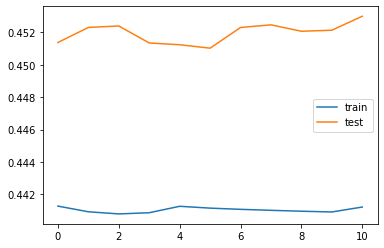

In [56]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()